# Sample MERRA-2 Along a CALIPSO Obrit
This is an example showing how to use GMAOpyobs utilities to sample MERRA-2 along a CALIPSO orbit.

This assumes that you have cloned the GMAOpyobs Github repository, installed it in a directory called \\$AERODIR, and have added the following directory to your $PYTHONPATh environment variable:
\\$AERODIR/install/lib/Python

It also assumes you have a grads style control file for the MERRA-2 files. An example of such a file is in this directory called inst3_3d_aer_Nv, and it points to files in a directory called MERRA2_all also in this directory.

The inst3_3d_aer_Nv MERRA-2 Collection contains 3-D aerosol mass mixing ratios on the native model vertical levels.

The CALIPSO Level2 file used in this example can be found at https://portal.nccs.nasa.gov/datashare/iesa/campaigns/ASIA-AQ/ipynb_examples/

The GEOS aerosol optics files can be found at https://portal.nccs.nasa.gov/datashare/iesa/aerosol/ExtData/


## CALIPSO Example

In [5]:
# You only need to do this if you're using the discover jupyterhub
# if you are, make sure to use the conda env:sci2 kernel
import sys
sys.path.append('/gpfsm/dnb34/pcastell/workspace/GMAOpyobs_ipynb_examples/GMAOpyobs/install/lib/Python')

In [6]:
from pyobs.sampler import TRAJECTORY
from pyobs.calipso_l2 import CALIPSO_L2

In [7]:
# set up some file names
calipsoFile = 'CAL_LID_L2_05kmAPro-Standard-V4-51.2016-08-17T05-02-55ZD.hdf'
m2data = 'inst3_3d_aer_Nv'
outFile = 'm2_calipso_sampled.nc4'

In [8]:
# Read the CALIPSO file, get the lat, lon, times from the file
caldata = CALIPSO_L2(calipsoFile,Verbose=True)

[] working on <CAL_LID_L2_05kmAPro-Standard-V4-51.2016-08-17T05-02-55ZD.hdf>
v Latitude
v Longitude
v Pressure
v Surface_Elevation_Statistics
v Temperature
v Total_Backscatter_Coefficient_532
v Total_Backscatter_Coefficient_Uncertainty_532
v Extinction_Coefficient_532
v Extinction_Coefficient_Uncertainty_532
shape Latitude (4208, 3)
shape Longitude (4208, 3)
shape Profile_UTC_Time (4208, 3)
shape Pressure (4208, 399)
shape Surface_Elevation_Statistics (4208, 4)
shape Temperature (4208, 399)
shape Total_Backscatter_Coefficient_532 (4208, 399)
shape Total_Backscatter_Coefficient_Uncertainty_532 (4208, 399)
shape Extinction_Coefficient_532 (4208, 399)
shape Extinction_Coefficient_Uncertainty_532 (4208, 399)
shape nymd (17707264,)
shape nhms (17707264,)


In [9]:
# create a trajectory oject
time, lon, lat = caldata.time, caldata.lon[:,1], caldata.lat[:,1]
traj = TRAJECTORY(time,lon,lat,m2data)

In [10]:
# sample the MERRA-2 dataset along the trajectory, and return an xarray dataset
traj_ds = traj.sample()

In [11]:
# write sampled data to a netcdf file
traj_ds.to_netcdf(outFile)

# Calculate Aerosol Optical Properties on the Sampled Dataset
Now that we have the 3-D aerosol mass mixing ratios, we would like to convert this to 3-D total and speciated aerosol optical properties.
You will need the aerosol optics tables, and a yaml file describing which files to use.
An example yaml file called m2_pm25.yaml can be found in the  directory GMAOpyobs/src/config. 
It points to optics files located in the directory ExtData.


In [12]:
from pyobs.aop import G2GAOP

In [13]:
# set up some filenames
config = 'm2_pm25.yaml'

In [14]:
# read the sampled aerosol profile data and optical tables
optics = G2GAOP(outFile,config=config)

In [15]:
# caluclate profiles of total:
#        EXT:     aerosol extinction profile
#        SCA:     aerosol scattering profile
#        BSC:     aerosol backscatter profile
#        DEPOL:   aerosol depolarization ratio
# at 532 nm
ext532 = optics.getAOPext(wavelength=532)

In [16]:
# write this to a file
outFile = 'm2_calipso_ext532.nc4'
ext532.to_netcdf(outFile)

In [17]:
# calculate profile of EXT, SCA, BSC, and DEPOL for a each species individually at 532 nm
ee = []
ext532_du = optics.getAOPext(Species='DU',wavelength=532)  # dust
ee.append(ext532_du)
ext532_su = optics.getAOPext(Species='SU',wavelength=532)  # sulfate
ee.append(ext532_su)
ext532_ss = optics.getAOPext(Species='SS',wavelength=532)  # sea salt
ee.append(ext532_ss)
ext532_cc = optics.getAOPext(Species=['OC','BC'],wavelength=532) # organic carbon plus black carbon
ee.append(ext532_cc)

In [18]:
# write these to file
SPC = ['DU','SU','SS','CC']
for spc,ext in zip(SPC,ee):
    outFile = 'm2_calipso_ext532_{}.nc4'.format(spc)
    ext.to_netcdf(outFile)

In [19]:
# calculate profiles of total:
#       AOT: aerosol layer optocal thickness
#       SSA: single scattering albedo
#       G: assymetry parameter
rt532 = optics.getAOPrt(wavelength=532)

# per species
rt532_du = optics.getAOPrt(Species='DU',wavelength=532)

In [20]:
# write these to file
outFile = 'm2_calipso_rt532.nc4'
rt532.to_netcdf(outFile)

## Compare MERRA-2 532 nm Extinction Profile to CALIPSO Retrieval

In [21]:
import matplotlib.pyplot as plt
from pyobs.sampler import addVertCoord

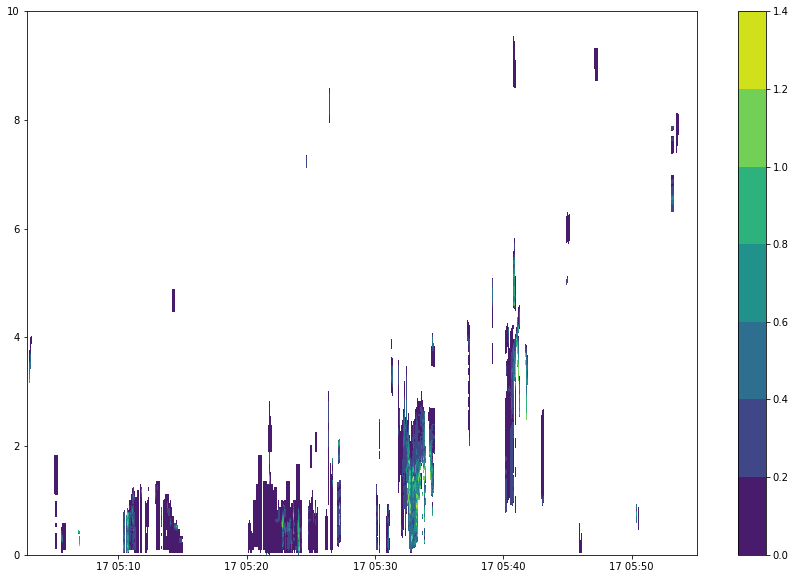

In [22]:
# Plot CALIPSO

# Get the CALIPSO vertical coordinate
npts, nstats = caldata.surfelev.shape
nlev = len(caldata.alt)
caldata.z = np.transpose(caldata.surfelev[:,2] + np.repeat(caldata.alt.reshape(nlev,1),npts,axis=1))

# Get time coordinate
time = caldata.time
ntime = len(time)
time = np.repeat(time.reshape(ntime,1),nlev,axis=1)

# Plotting part
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.contourf(time,caldata.z,caldata.ext)
ax.set_ylim(0,10)
plt.colorbar(im,ax=ax)

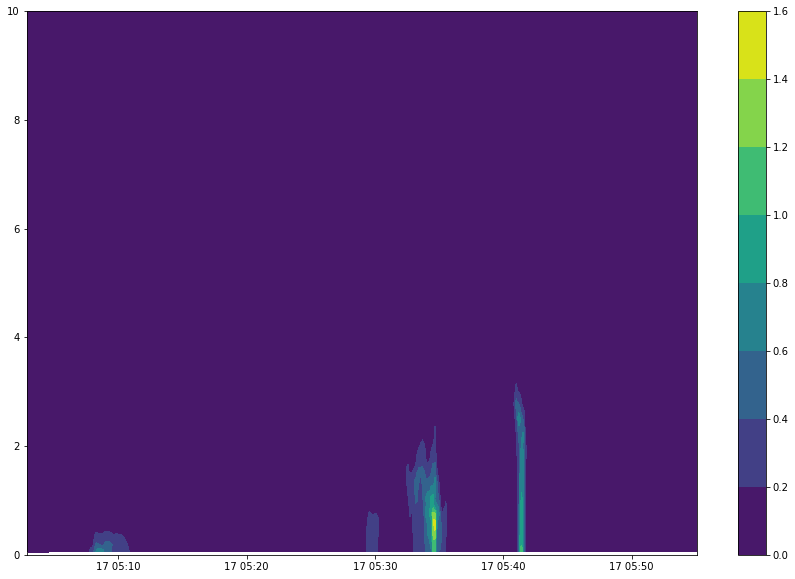

In [23]:
# Plot MERRA-2

# Get MERRA-2 vertical coordinate
ext532.pipe(addVertCoord)

# Get time coordinate
time = ext532.time.values
ntime = ext532.dims['time']
nlev = ext532.dims['lev']
time = np.repeat(time.reshape(ntime,1),nlev,axis=1)

# plotting part
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.contourf(time,ext532.Z,ext532.EXT)
ax.set_ylim(0,10)
plt.colorbar(im,ax=ax)